In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


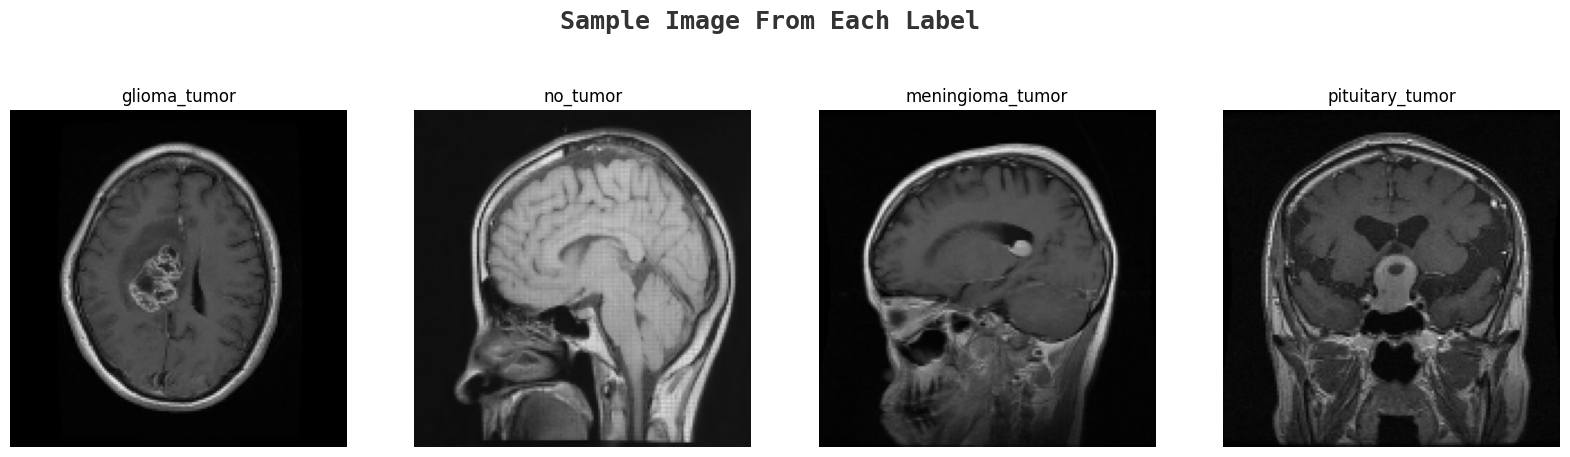

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2946, 150, 150, 3)

In [ ]:
X_test.shape

(328, 150, 150, 3)

In [ ]:
y_train.shape

(2946,)

In [ ]:
y_test.shape

(328,)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



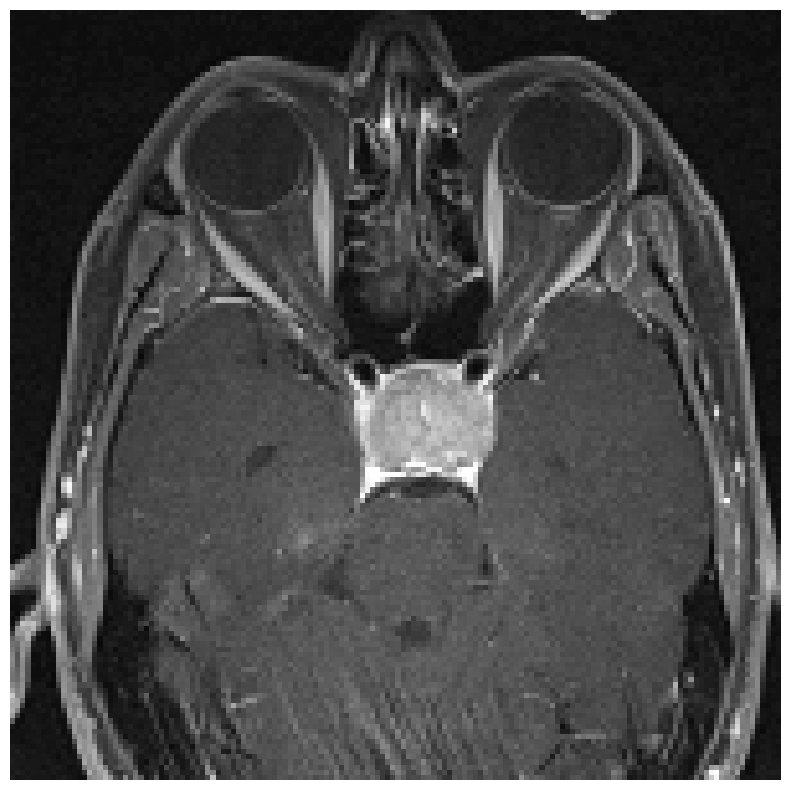

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.8189
Epoch 1: val_accuracy improved from -inf to 0.86102, saving model to effnet.keras
83/83 [==============================] - 57s 197ms/step - loss: 0.4847 - accuracy: 0.8189 - val_loss: 0.4024 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9370
Epoch 2: val_accuracy improved from 0.86102 to 0.87119, saving model to effnet.keras
83/83 [==============================] - 12s 144ms/step - loss: 0.1928 - accuracy: 0.9370 - val_loss: 0.3317 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9578
Epoch 3: val_accuracy improved from 0.87119 to 0.89492, saving model to effnet.keras
83/83 [==============================] - 12s 150ms/step - loss: 0.1283 - accuracy: 0.9578 - val_loss: 0.3284 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 4/5
83/83 [=================

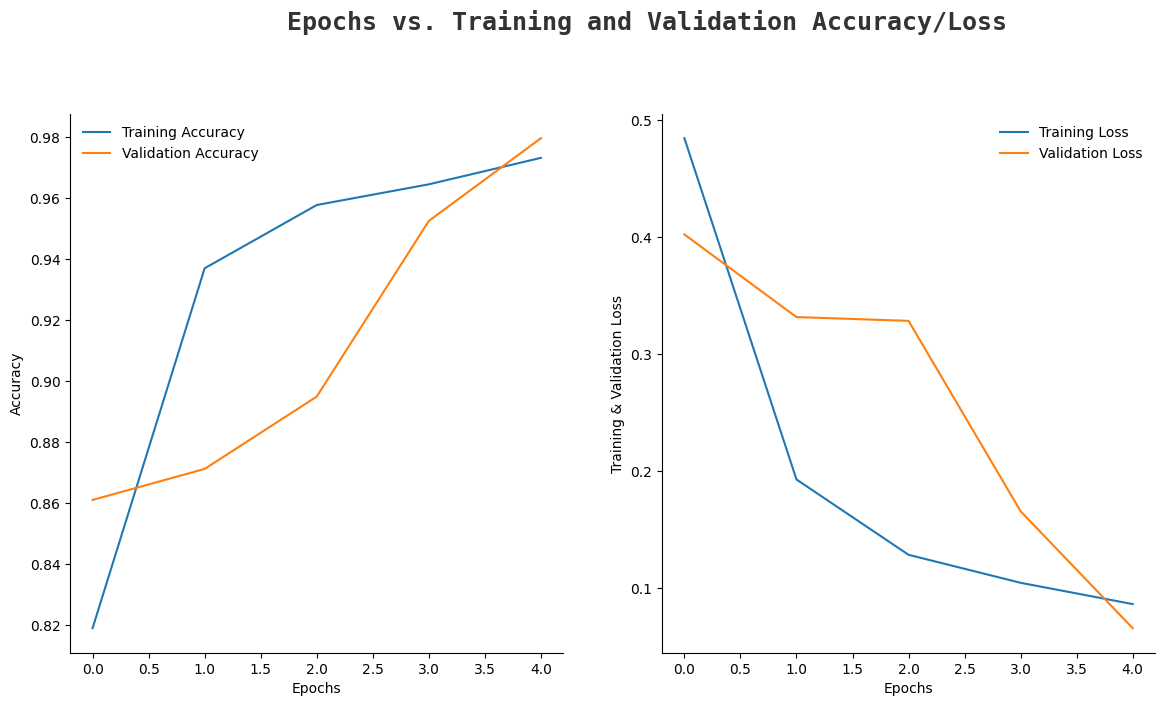

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

# Create a new sequential model for RNN
model_rnn = Sequential()

# Add a SimpleRNN layer with 64 units
model_rnn.add(SimpleRNN(64, input_shape=(10, 1)))  # Input shape: (sequence_length, input_dim)
model_rnn.add(Dropout(0.2))

# Add a Dense layer for classification
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(4, activation='softmax'))  # Adjust the number of units for your specific classification problem

# Compile the model
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 21060 (82.27 KB)
Trainable params: 21060 (82.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Flatten, Reshape # Import Reshape
from tensorflow.keras.optimizers import Adam

# Create a new sequential model for RNN
model_rnn = Sequential()

# Flatten each image into a single vector
model_rnn.add(Flatten(input_shape=(224, 224, 3)))

# Reshape to fit the RNN input shape (sequence_length, input_dim)
model_rnn.add(Dense(10, activation='relu'))  # Adjust `10` based on your sequence length
model_rnn.add(Reshape((10, 1)))  # Reshape to (sequence_length, input_dim)

# Add a SimpleRNN layer with 64 units
model_rnn.add(SimpleRNN(64))

# Add Dropout for regularization
model_rnn.add(Dropout(0.2))

# Add Dense layers for classification
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(4, activation='softmax'))  # Adjust the number of units for your specific classification problem

# Compile the model
model_rnn.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_5 (Dense)             (None, 10)                1505290   
                                                                 
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)               

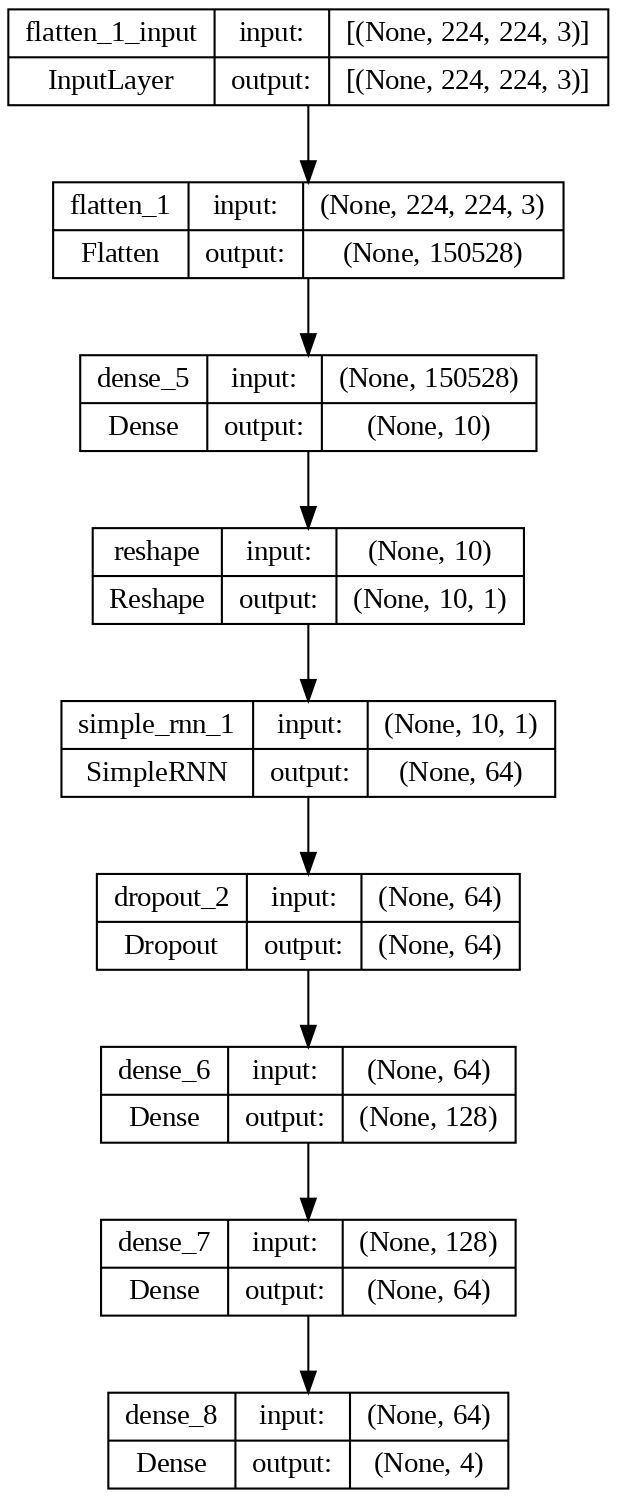

In [ ]:

# Display the plot of the model architecture
plot_model(model_rnn, show_shapes=True, dpi=150)

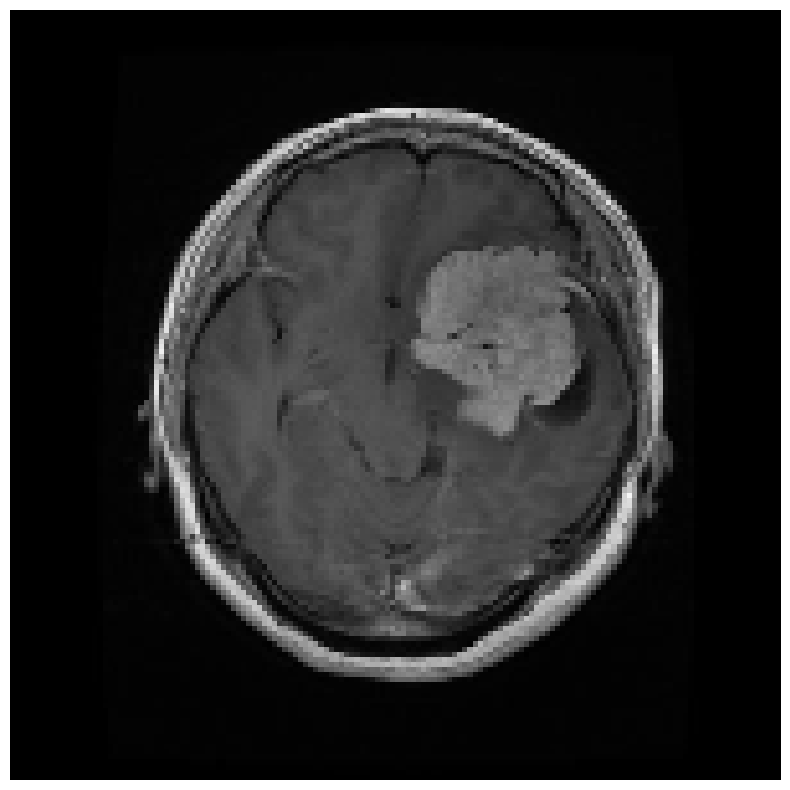

In [ ]:
plot_model(model_rnn, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)

In [ ]:
model_rnn.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
history = model_rnn.fit(resized_X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
80/83 [===========================>..] - ETA: 0s - loss: 1.3576 - accuracy: 0.2855
Epoch 1: val_accuracy did not improve from 0.97966
83/83 [==============================] - 2s 25ms/step - loss: 1.3586 - accuracy: 0.2867 - val_loss: 1.3592 - val_accuracy: 0.2915 - lr: 8.1000e-06
Epoch 2/30
82/83 [============================>.] - ETA: 0s - loss: 1.3592 - accuracy: 0.2843
Epoch 2: val_accuracy did not improve from 0.97966
83/83 [==============================] - 1s 16ms/step - loss: 1.3587 - accuracy: 0.2852 - val_loss: 1.3592 - val_accuracy: 0.2915 - lr: 8.1000e-06
Epoch 3/30
82/83 [============================>.] - ETA: 0s - loss: 1.3604 - accuracy: 0.2797
Epoch 3: val_accuracy did not improve from 0.97966

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
83/83 [==============================] - 1s 16ms/step - loss: 1.3598 - accuracy: 0.2806 - val_loss: 1.3591 - val_accuracy: 0.2915 - lr: 8.1000e-06
Epoch 4/30
83/83 [=============================

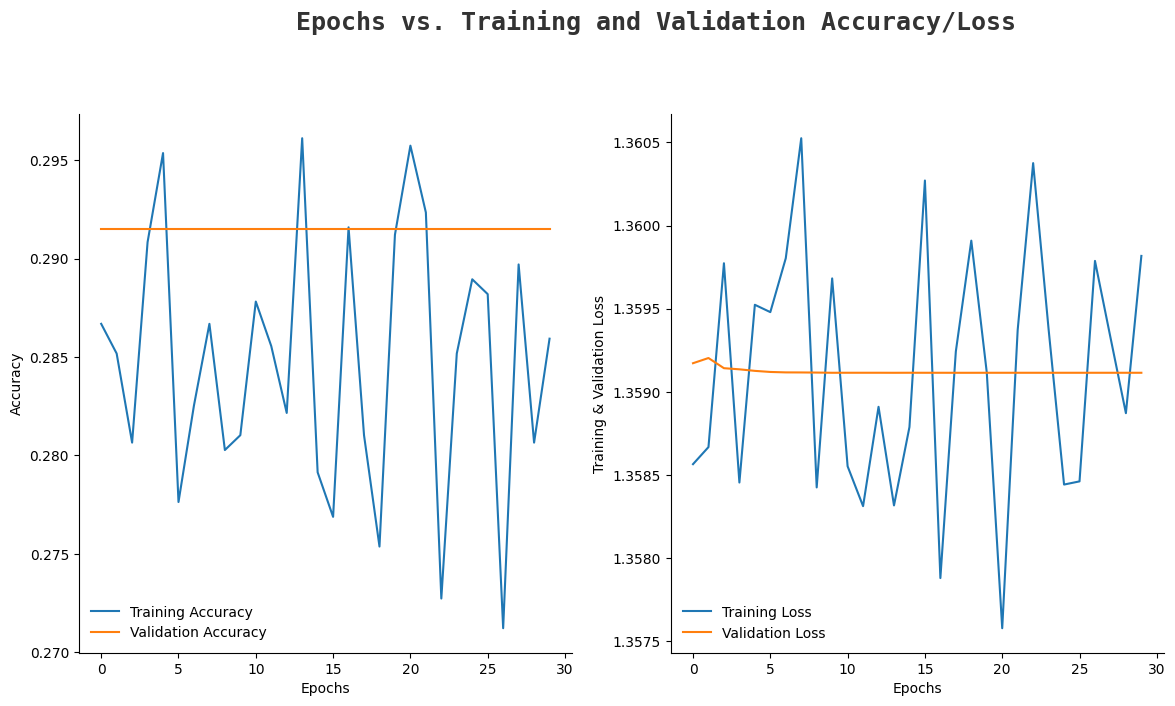

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model_rnn.predict(resized_X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 1s 7ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.00      0.00      0.00        51
           2       0.27      1.00      0.43        89
           3       0.00      0.00      0.00        91

    accuracy                           0.27       328
   macro avg       0.07      0.25      0.11       328
weighted avg       0.07      0.27      0.12       328



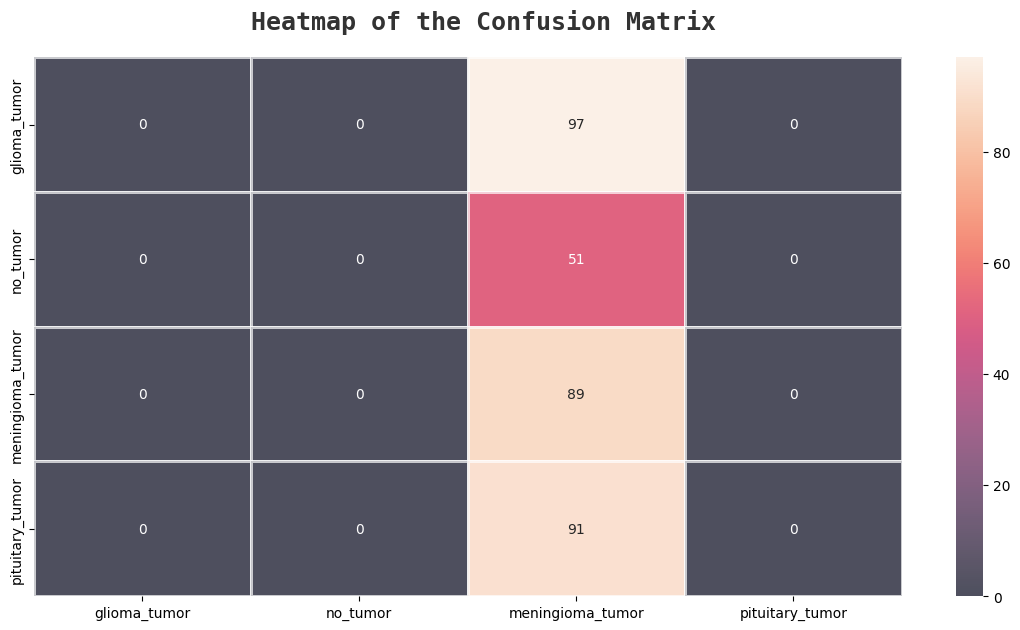

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
model.save("/content/drive/MyDrive/MRI_classification_saved/brain_rnn.h5")